## Prepare data

In [1]:
#import the library
import scanpy as sc
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb
import seaborn as sns
import logging
#import tensorflow as tf
import os
import anndata

import importlib
import warnings
warnings.filterwarnings("ignore")
import pickle as pkl
from matplotlib.colors import LinearSegmentedColormap

In [3]:
from matplotlib.colors import LinearSegmentedColormap
values = [0,1]
colors = [(227, 227, 227), (255, 42, 18)]
norm = plt.Normalize(min(values), max(values))
my_cmap = LinearSegmentedColormap.from_list(
    '', [(norm(value), tuple(np.array(color) / 255)) for value, color in zip(values, colors)])

In [16]:
import ipympl
import matplotlib.collections as mcoll
from adjustText import adjust_text
import matplotlib.patheffects as PathEffects

class DraggableText:
    def __init__(self, text):
        self.text = text
        text.set_picker(True)  # enable pick events on the text
        self.press = None
        # connect pick event
        text.figure.canvas.mpl_connect('pick_event', self.on_pick)

    def on_pick(self, event):
        if event.artist is not self.text: return
        x0, y0 = self.text.get_position()
        xpress, ypress = event.mouseevent.xdata, event.mouseevent.ydata
        self.press = (x0, y0, xpress, ypress)
        # connect motion and release
        self.cidmotion = self.text.figure.canvas.mpl_connect(
            'motion_notify_event', self.on_motion)
        self.cidrelease = self.text.figure.canvas.mpl_connect(
            'button_release_event', self.on_release)

    def on_motion(self, event):
        if self.press is None or event.xdata is None: return
        x0, y0, xpress, ypress = self.press
        dx, dy = event.xdata - xpress, event.ydata - ypress
        self.text.set_position((x0 + dx, y0 + dy))
        self.text.figure.canvas.draw_idle()

    def on_release(self, event):
        # disconnect the motion/release callbacks
        self.text.figure.canvas.mpl_disconnect(self.cidmotion)
        self.text.figure.canvas.mpl_disconnect(self.cidrelease)
        self.press = None

In [10]:
general_palette = ['#118AB2','#06d6a0','#EF476F','#ffd166']

In [4]:
os.chdir(r'F:\gdT_aim2\Geneformer')
adata = sc.read_h5ad(r"F:\gdT_aim2\organized_data\unimputed\gdT_integrated_clean.h5ad")

In [ ]:
# adata = sc.read_h5ad(r"F:\gdT_aim2\Geneformer\geneformer_gdT_canceronly_TRM_Teff.h5ad")

In [5]:
general_type = adata.obs['cell type'].astype(str)
general_type = general_type.replace({r'IL7R.* TRM':'TRM', r'^.*Teff.*':'Teff','^.*Tex.*':'Tex'},regex=True)
adata.obs['general_type'] = general_type

In [20]:
adata_crc = adata[(adata.obs['tissue']=='Carcinoma')]

In [18]:
sc.pp.filter_genes(adata_crc, min_counts=1)
sc.pp.highly_variable_genes(adata_crc, flavor='seurat_v3', n_top_genes=1000)
print('\n','Number of highly variable genes: {:d}'.format(np.sum(adata_crc.var['highly_variable'])))
sc.pp.pca(adata_crc, n_comps=50, use_highly_variable=True, svd_solver='arpack')
sc.pp.neighbors(adata_crc, n_neighbors = 15, n_pcs = 50)
sc.tl.umap(adata_crc, min_dist = 3, spread = 1.5)


 Number of highly variable genes: 1000


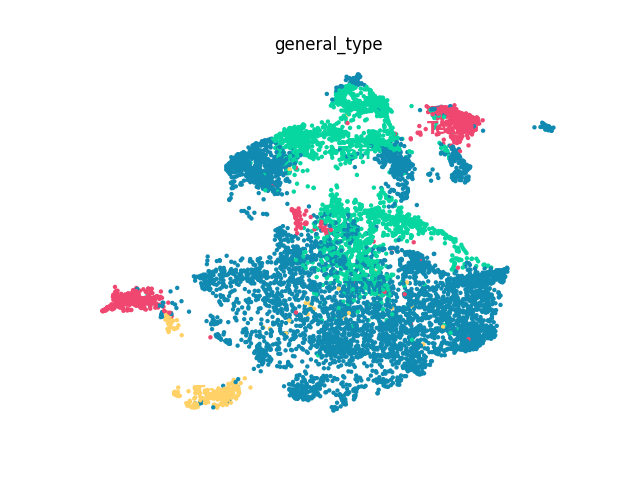

In [21]:
%matplotlib widget

fig = sc.pl.umap(
    adata_crc,
    color='general_type',
    size=40, 
    ncols=1,
    palette=general_palette,
    return_fig=True,
    legend_fontsize='large',
    legend_loc='on data',
    frameon=False
)

axes = fig.get_axes()
for ax in axes:
    # grab the scatter PathCollections
    scatter_objs = [
        coll for coll in ax.collections
        if isinstance(coll, mcoll.PathCollection)
    ]
    # grab all the Text labels
    texts = ax.texts
    
    for i, txt in enumerate(texts):
        label = txt.get_text()                       # e.g. 'CD16- mono'
        facecolor = general_palette[i]        # grab the correct HEX
        txt.set_color(facecolor)                     # set the text fill
        # txt.set_fontsize(20)
        # if label not in ['Plasma','CD8ab TRM','CD8aa MAIT','Memory B','CD4 Treg']:
        #     txt.set_path_effects([                       # add a black outline
        #         PathEffects.withStroke(linewidth=2, foreground='black')
        #     ])
    draggables = [DraggableText(txt) for txt in texts]
    #     adjust_text(
#         texts,
#         ax=ax,
#         avoid_objects=scatter_objs,    # ← use this kwarg
#         expand_points=(3, 3),          # ← inflate point bboxes by 3×
#         expand_objects=(1.2, 1.2),     # ← optional, inflate artist bboxes
#         arrowprops=dict(arrowstyle='->', color='gray'),
#         only_move={'points':'y','text':'xy'},
#         force_text=(0.1, 0.25),
#         force_points=(0.1, 0.25),
#         save_steps=False
#     )

# sc.pl.umap(adata,color = 'general_type', palette=general_palette)

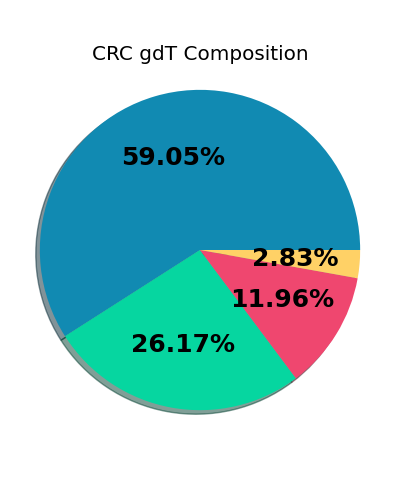

In [49]:
plt.rcParams['figure.figsize'] = [4,5]
plt.rcParams.update({'font.size': 12, 'font.weight': 'bold','axes.linewidth':2})
plt.close()
patches, texts, autotexts =plt.pie([float(i) for i in pd.DataFrame(adata_crc.obs['general_type'].value_counts(normalize=True)).reindex(index = ['TRM','Teff','Tex','Tpex']).values],
              autopct='%1.2f%%',
              colors = general_palette,shadow=True, radius=1.1)
plt.setp(autotexts, size=18, weight="bold")
plt.title('CRC gdT Composition')
# plt.savefig('SiteComposition.png',dpi = 300,bbox_inches='tight')
plt.tight_layout()
plt.show()
# plt.savefig('vis/gut_nonimmune_celltype_breakdown.png',dpi = 300)

In [50]:
adata_crc

AnnData object with n_obs × n_vars = 9201 × 19818
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'patient', 'tissue', 'gender', 'age', 'site', 'TNM_T', 'TNM_N', 'TNM_M', 'stage', 'percent.mt', 'leiden', 'cell type', 'general_type'
    var: 'highly_variable'
    uns: 'TNM_M_colors', 'TNM_N_colors', 'TNM_T_colors', 'cell type_colors', 'cell type_sizes', 'gender_colors', 'leiden_colors', 'neighbors', 'orig.ident_colors', 'paga', 'site_colors', 'stage_colors', 'tissue_colors', 'umap', 'general_type_colors'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    layers: 'counts', 'logcounts'
    obsp: 'connectivities', 'distances'

In [17]:
# adata_geneformer = adata[(adata.obs['tissue']=='Carcinoma') & (adata.obs['general_type'].isin(['TRM','Teff']))]
adata_geneformer = adata[(adata.obs['tissue']=='Carcinoma') & (adata.obs['general_type'].isin(['Tex','Teff']))]
del adata_geneformer.var
del adata_geneformer.obsm

In [18]:
adata_geneformer

AnnData object with n_obs × n_vars = 3508 × 19818
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'patient', 'tissue', 'gender', 'age', 'site', 'TNM_T', 'TNM_N', 'TNM_M', 'stage', 'percent.mt', 'leiden', 'cell type', 'general type', 'general_type'
    uns: 'TNM_M_colors', 'TNM_N_colors', 'TNM_T_colors', 'cell type_colors', 'cell type_sizes', 'gender_colors', 'leiden_colors', 'neighbors', 'orig.ident_colors', 'paga', 'site_colors', 'stage_colors', 'tissue_colors', 'umap'
    layers: 'counts', 'logcounts'
    obsp: 'connectivities', 'distances'

In [19]:
gene2tx = pd.read_csv('tx2gene_grch38_ens94.txt',sep = '\t',usecols = ['ensgene','symbol']).drop_duplicates(subset = 'symbol')
gene2tx.index = gene2tx['symbol']

In [21]:
adata_geneformer = adata_geneformer[:,adata_geneformer.var_names.isin(gene2tx.index)]

In [22]:
ens_id = gene2tx['ensgene'].loc[adata_geneformer.var_names]
adata_geneformer.var['ensembl_id'] = ens_id

In [23]:
adata_geneformer.X = sp.sparse.csc_matrix(adata_geneformer.X)

In [24]:
adata_geneformer.obs = adata_geneformer.obs.astype(str)
adata_geneformer.var = adata_geneformer.var.astype(str)

In [25]:
adata_geneformer.obs['n_counts'] = adata_geneformer.obs['nCount_RNA'].astype(float)

In [26]:
# adata_geneformer.write("geneformer_gdT_canceronly_TRM_Teff.h5ad")
adata_geneformer.write("geneformer_gdT_canceronly_Tex_Teff.h5ad")

## Activation scores and exhaustion scores

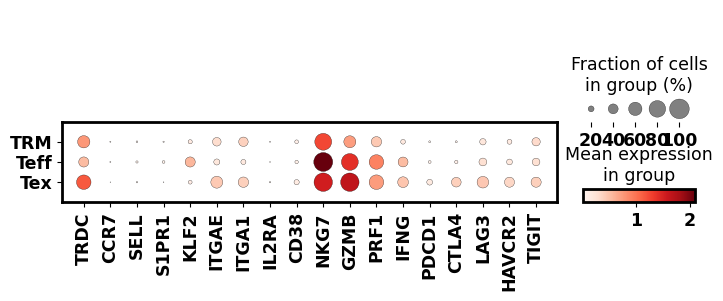

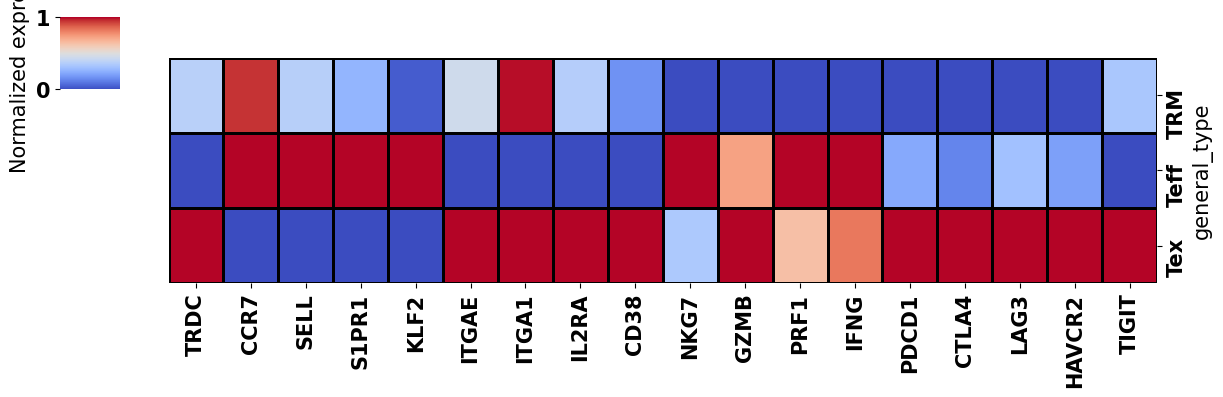

In [6]:
plt.rcParams.update({'font.size': 15, 'font.weight': 'heavy','axes.linewidth':2,'figure.figsize':[8,8]})
adata_vis = adata[(adata.obs['tissue']=='Carcinoma') & (adata.obs['general_type'].isin(['Tex','Teff','TRM']))]
sc.pl.dotplot(adata_vis,groupby='general_type',var_names = ['TRDC','CCR7','SELL','S1PR1','KLF2','ITGAE','ITGA1','IL2RA','CD38','NKG7','GZMB','PRF1','IFNG','PDCD1', 'CTLA4', 'LAG3', 'HAVCR2', 'TIGIT'])

adata_vis_df = adata_vis[:,['TRDC','CCR7','SELL','S1PR1','KLF2','ITGAE','ITGA1','IL2RA','CD38','NKG7','GZMB','PRF1','IFNG','PDCD1', 'CTLA4', 'LAG3', 'HAVCR2', 'TIGIT']].to_df()
adata_vis_df['general_type'] = adata_vis.obs['general_type'] 

kwargs = {'cmap': 'coolwarm'}
heatmap_df = adata_vis_df.groupby(['general_type']).mean().unstack().unstack().T
heatmap_df_norm = (heatmap_df-heatmap_df.min())/(heatmap_df.max()-heatmap_df.min()+0.000001)
clustergrid = sns.clustermap(heatmap_df_norm,figsize = (12,4),linewidths=2,
                linecolor = 'k',dendrogram_ratio = 0.1, colors_ratio = 0.5,vmin = 0, vmax = 1,
                row_cluster = False,col_cluster = False,cbar_kws={'label': 'Normalized expression','location':"left"},
                **kwargs)


In [7]:
act_gene_list = [ 'IL2RA','CD38','NKG7','GZMB','PRF1','IFNG']
sc.tl.score_genes(adata, gene_list=act_gene_list, score_name='act_score', ctrl_size=6)
exhaust_gene_list = [ 'PDCD1', 'CTLA4', 'LAG3', 'HAVCR2', 'TIGIT']
sc.tl.score_genes(adata, gene_list=exhaust_gene_list, score_name='ex_score', ctrl_size=6)

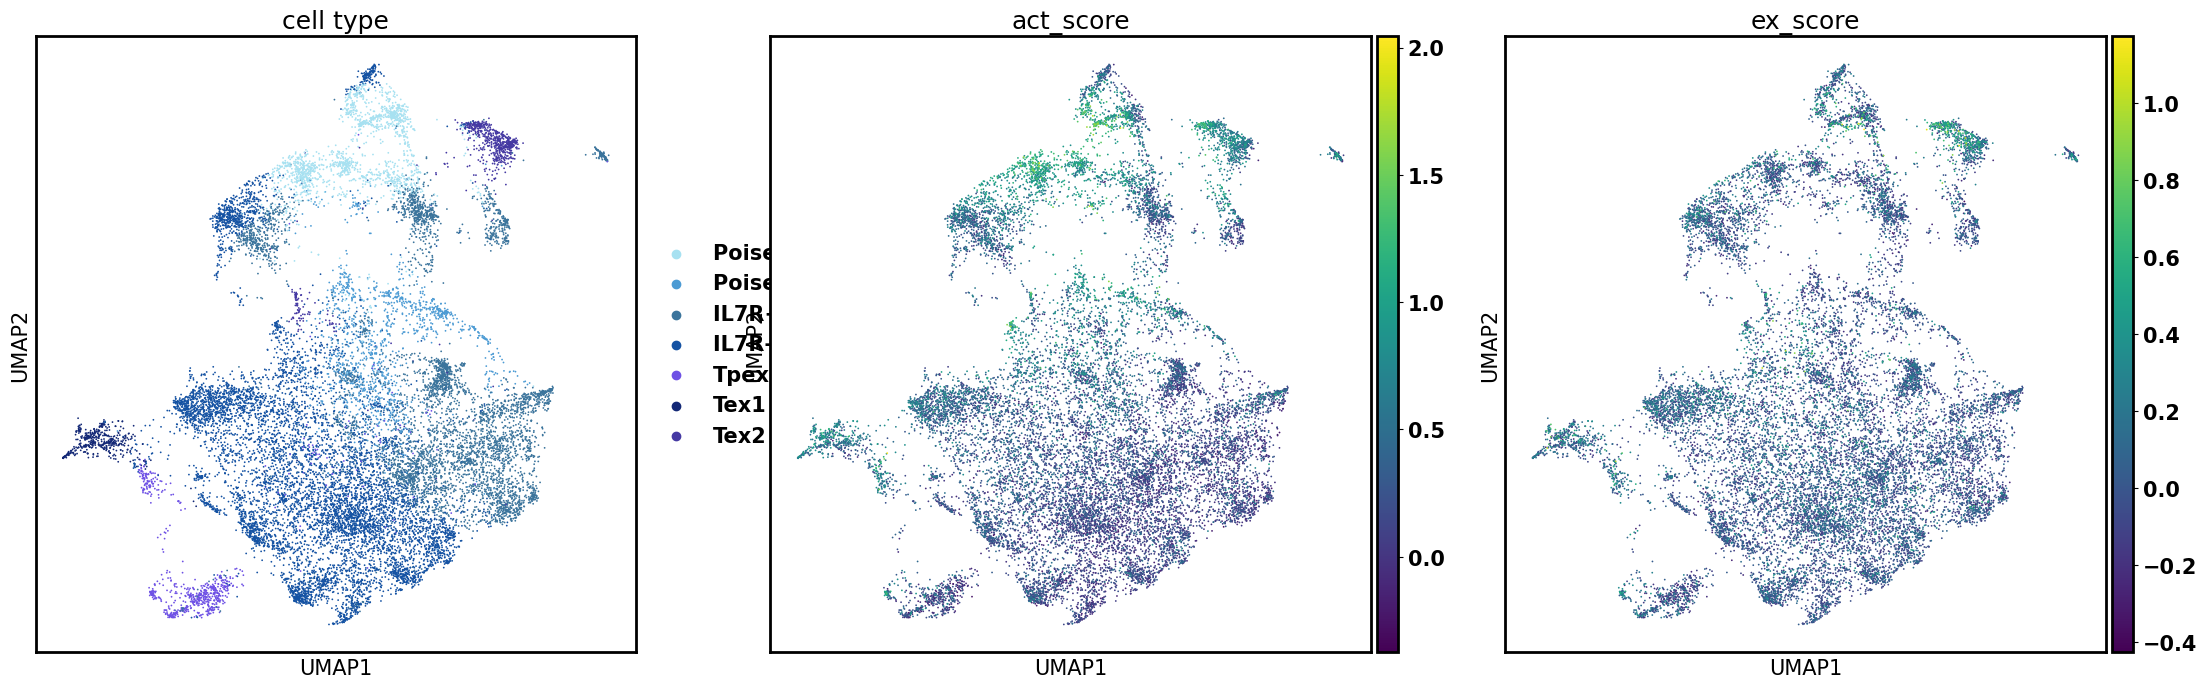

In [8]:
sc.pl.umap(adata,color = ['cell type','act_score','ex_score'])

In [9]:
color_dict = {}
cell_type_palette = ['#a7e1f1', '#4c9bd4', '#3b749c', '#1452a3', '#6e51e5', '#132876','#4539a3']
for i, ii in enumerate(adata.obs['cell type'].values.categories):
    color_dict[ii] = cell_type_palette[i]

Text(0, 0.5, 'exhaustion score')

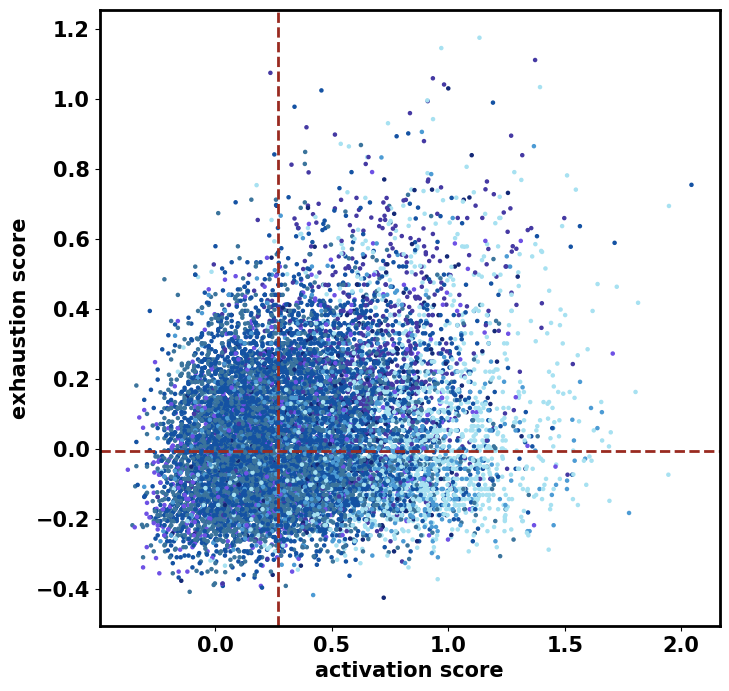

In [10]:
adata.obs['cell type colors'] = adata.obs['cell type'].replace(color_dict)
plt.rcParams.update({'font.size': 15, 'font.weight': 'heavy','axes.linewidth':2,'figure.figsize':[8,8]})
plt.scatter(adata.obs['act_score'],adata.obs['ex_score'], c=adata.obs['cell type colors'], s = 5)
act_thresh = np.percentile(adata.obs['act_score'].values, 50)
ex_thresh = np.percentile(adata.obs['ex_score'].values, 50)
plt.axvline(act_thresh,color = '#992A20', linestyle = '--',linewidth =2)
plt.axhline(ex_thresh,color = '#992A20', linestyle = '--',linewidth =2)
plt.xlabel('activation score', fontsize = 15, fontweight = 'bold')
plt.ylabel('exhaustion score', fontsize = 15, fontweight = 'bold')

<Axes: xlabel='cell type', ylabel='Score'>

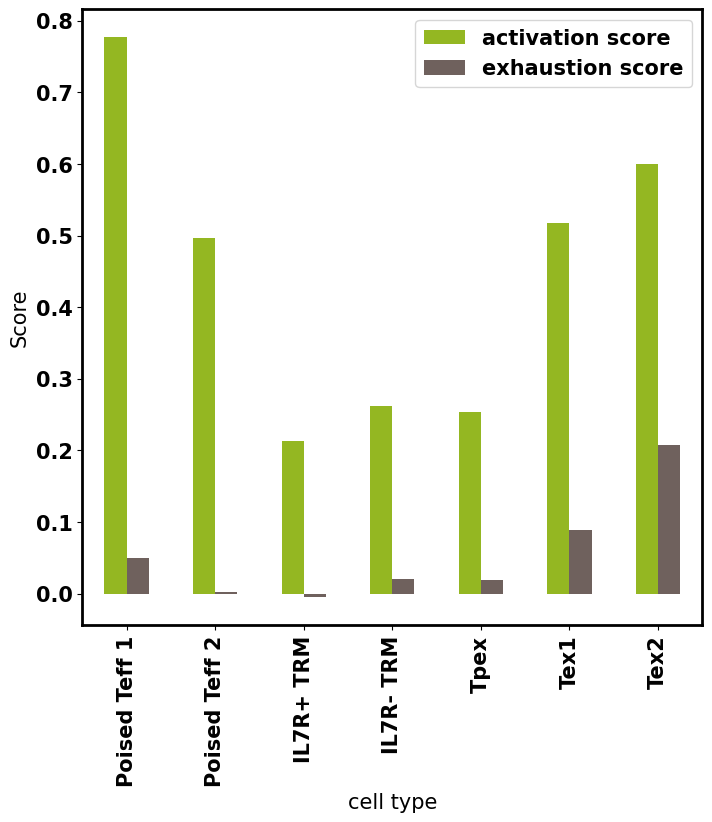

In [11]:
plt.rcParams.update({'font.size': 15, 'font.weight': 'heavy','axes.linewidth':2,'figure.figsize':[8,8]})
vis_df = pd.DataFrame([adata.obs.groupby('cell type')['act_score'].mean(), adata.obs.groupby('cell type')['ex_score'].mean()]).T
vis_df.columns = ['activation score','exhaustion score']
vis_df.plot.bar(color = ['#94B722','#6F615D'],
                ylabel = 'Score')

In [12]:
adata_subset = adata[(adata.obs['ex_score']<ex_thresh)&(adata.obs['tissue']=='Carcinoma')]
adata_subset.obs['activation'] = 'low'
adata_subset.obs['activation'][adata_subset.obs['act_score']>act_thresh] = 'high'

In [ ]:
#113 got from biomart
txid = pd.read_csv('mart_export_withcount.txt',sep = '\t')
del txid['Transcript stable ID']
del txid['Transcript count']
txid = txid.drop_duplicates()

map_dict = txid[~txid['Gene name'].isna()]
map_dict_deduplicated = map_dict.drop_duplicates(subset = 'Gene name',keep = 'last')

map_dict_deduplicated.index = map_dict_deduplicated['Gene name']
# txid['Gene name and ID'] = txid['Gene name'].astype(str).map(str) +'_'+ txid.index.astype(str).map(str)
# txid['Gene name and ID'][txid['Gene name'].isna()] = txid.index.astype(str)[txid['Gene name'].isna()]
# txid['Name'] = txid['Gene name']
# txid['Name'][pd.DataFrame(txid['Gene name']).duplicated()] = txid['Gene name and ID'][pd.DataFrame(txid['Gene name']).duplicated()] 
id_table = pd.DataFrame(map_dict_deduplicated['Gene stable ID']).T
id_dict = id_table.to_dict(orient = 'records')[0]#index = False)

adata_subset = adata_subset[:,adata_subset.var_names.isin(map_dict_deduplicated['Gene name'])]
ensgid = pd.DataFrame(adata_subset.var_names).replace(id_dict).values
adata_subset.var['ensembl_id'] = ensgid.flatten().tolist()

In [13]:
# alternatively
gene2tx = pd.read_csv('tx2gene_grch38_ens94.txt',sep = '\t',usecols = ['ensgene','symbol']).drop_duplicates(subset = 'symbol')
gene2tx.index = gene2tx['symbol']
adata_subset = adata_subset[:,adata_subset.var_names.isin(gene2tx.index)]
ens_id = gene2tx['ensgene'].loc[adata_subset.var_names]
adata_subset.var['ensembl_id'] = ens_id

In [14]:
adata_subset.X = sp.sparse.csc_matrix(adata_subset.X)
adata_subset.obs = adata_subset.obs.astype(str)
adata_subset.var = adata_subset.var.astype(str)
adata_subset.obs['n_counts'] = adata_subset.obs['nCount_RNA'].astype(float)
# adata_subset.write("geneformer_gdT_canceronly_TRM_Teff.h5ad")
adata_subset.write("geneformer_gdT_canceronly_high_low_act_2_cancer_only.h5ad")

<Axes: title={'center': 'Tumor-infiltrating gdT'}, xlabel='general_type', ylabel='Score'>

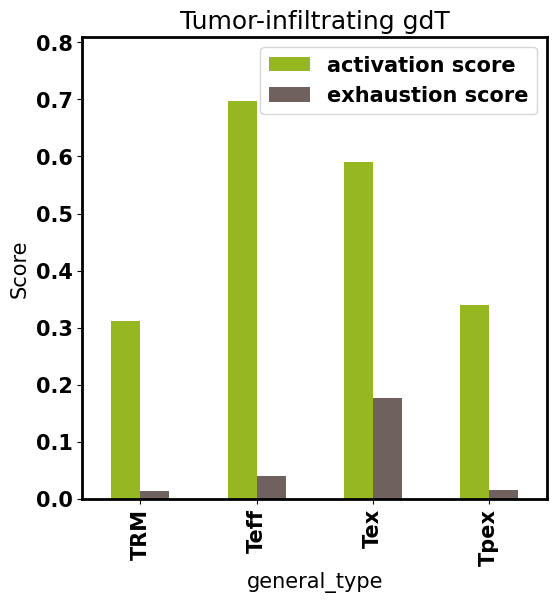

In [30]:
plt.rcParams.update({'font.size': 15, 'font.weight': 'heavy','axes.linewidth':2,'figure.figsize':[6,6]})
adata_ti = adata[adata.obs['tissue']=='Carcinoma']
adata_ti.obs['act_score'] = adata_ti.obs['act_score'].astype(float)
adata_ti.obs['ex_score'] = adata_ti.obs['ex_score'].astype(float)
vis_df = pd.DataFrame([adata_ti.obs.groupby('general_type')['act_score'].mean(), adata_ti.obs.groupby('general_type')['ex_score'].mean()]).T
vis_df.columns = ['activation score','exhaustion score']
vis_df.plot.bar(color = ['#94B722','#6F615D'],
                ylabel = 'Score',
                title = 'Tumor-infiltrating gdT',ylim = [0,0.81])